# 模型低秩分解压缩实战

本实践将利用低秩分解方法中的SVD（奇异值分解）对预训练的LeNet模型进行低秩分解，以达到模型压缩的目的。
我们将比较不同压缩率下的模型精度，并探索两种压缩策略：
1.  同时压缩卷积层和全连接层
2.  仅压缩全连接层

实验中，"压缩率"指的是参数减少的比例。例如，压缩率为0.3意味着模型参数量减少30%，即新模型的参数量约为原模型的70%。


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F

# 设置matplotlib字体以支持中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

## 1. 定义模型与辅助函数
首先，我们定义LeNet模型结构、数据加载函数和模型评估函数。这些是进行实验的基础。

In [2]:
# 定义LeNet模型
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载MNIST数据集
def get_mnist_loaders(batch_size=256):
    """获取MNIST测试数据加载器"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    test_dataset = torchvision.datasets.MNIST(root='../ch02/data/mnist', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# 评估模型准确率
@torch.no_grad()
def evaluate_model(model, test_loader):
    """在测试集上评估模型准确率"""
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

## 2. 加载预训练模型并评估基线

我们加载在`ch02`中训练好的LeNet模型，并评估其在测试集上的原始准确率，作为后续比较的基准。

In [3]:
# 加载原始模型
original_model = LeNet().to(device)
try:
    # 确保模型路径正确
    original_model.load_state_dict(torch.load('../ch02/model.pt', map_location=device))
except FileNotFoundError:
    print("错误：找不到预训练模型 '../ch02/model.pt'。请先运行ch02的训练脚本。")
    # 如果找不到预训练模型，则使用随机初始化的模型，准确率会很低
    original_model = LeNet().to(device)

# 获取测试数据
test_loader = get_mnist_loaders()

# 评估原始模型
baseline_accuracy = evaluate_model(original_model, test_loader)
print(f'原始模型准确率: {baseline_accuracy:.2f}%')

/tmp/ipykernel_648907/3958173910.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load('./ch02/model.pt', map_location=device))


原始模型准确率: 97.99%


## 3. SVD压缩核心函数

接下来，我们定义执行SVD分解和压缩的核心函数。我们将分别为全连接层和卷积层创建压缩函数。

In [4]:
def count_parameters(model):
    """计算模型的总参数量"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def svd_compress_linear(layer, compression_rate):
    """使用SVD压缩全连接层"""
    # 提取权重和偏置
    weight = layer.weight.data
    bias = layer.bias.data
    
    # 计算原始参数量
    in_features = layer.in_features
    out_features = layer.out_features
    original_params = in_features * out_features
    
    # 根据压缩率计算目标秩
    # 新参数量 = (in_features * rank) + (rank * out_features)
    # (1 - compression_rate) * original_params = rank * (in_features + out_features)
    target_rank = int((1 - compression_rate) * original_params / (in_features + out_features))
    
    # 保证秩至少为1且不超过最大可能秩
    max_rank = min(in_features, out_features)
    rank = max(1, min(target_rank, max_rank))
    
    # SVD分解
    U, S, V = torch.svd(weight)
    
    # 构建两个新的权重矩阵
    # W ≈ U_k @ S_k @ V_k.T
    # W' = A @ B, 其中 A = U_k @ sqrt(S_k), B = sqrt(S_k) @ V_k.T
    A = U[:, :rank] @ torch.diag(torch.sqrt(S[:rank]))
    B = torch.diag(torch.sqrt(S[:rank])) @ V[:, :rank].T
    
    # 创建新的两个线性层
    layer1 = nn.Linear(in_features, rank, bias=False).to(device)
    layer2 = nn.Linear(rank, out_features, bias=True).to(device)
    
    # 加载新的权重和原始偏置
    layer1.weight.data = B
    layer2.weight.data = A
    layer2.bias.data = bias
    
    # 返回一个包含两个新层的nn.Sequential模块
    return nn.Sequential(layer1, layer2)

def svd_compress_conv(layer, compression_rate):
    """使用SVD压缩卷积层"""
    # 提取权重和偏置
    weight = layer.weight.data
    bias = layer.bias.data
    
    # 获取卷积层参数
    out_channels, in_channels, kernel_size, _ = weight.shape
    stride = layer.stride
    padding = layer.padding
    
    # 将权重张量重塑为矩阵 (out_channels, in_channels * k * k)
    weight_matrix = weight.view(out_channels, -1)
    
    # 计算原始参数量和新参数量的单位
    original_params = weight_matrix.numel()
    params_per_rank = (in_channels * kernel_size * kernel_size) + out_channels
    
    # 根据压缩率计算目标秩
    target_rank = int((1 - compression_rate) * original_params / params_per_rank)
    rank = max(1, min(target_rank, out_channels))
    
    # SVD分解
    U, S, V = torch.svd(weight_matrix)
    
    # 构建两个新的权重矩阵
    # A(out_channels, rank) and B(rank, in_channels*k*k)
    A = U[:, :rank]
    B = torch.diag(S[:rank]) @ V[:, :rank].T
    
    # 创建新的两个卷积层
    # 第一个卷积层保持原始卷积核大小
    conv1 = nn.Conv2d(in_channels, rank, kernel_size=kernel_size, 
                      stride=stride, padding=padding, bias=False).to(device)
    # 第二个是1x1卷积
    conv2 = nn.Conv2d(rank, out_channels, kernel_size=1, 
                      stride=1, padding=0, bias=True).to(device)
    
    # 加载新的权重和原始偏置
    conv1.weight.data = B.view(rank, in_channels, kernel_size, kernel_size)
    conv2.weight.data = A.view(out_channels, rank, 1, 1)
    conv2.bias.data = bias
    
    return nn.Sequential(conv1, conv2)

## 4. 实验一：压缩卷积层与全连接层


在此实验中，我们将对LeNet模型的所有卷积层（`conv1`, `conv2`）和全连接层（`fc1`, `fc2`, `fc3`）应用SVD压缩，并观察不同压缩率对模型精度的影响。


In [5]:
compression_rates = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
accuracies_exp1 = []
original_params = count_parameters(original_model)

print("实验一：压缩所有层")
print(f"原始模型总参数量: {original_params}")
for rate in compression_rates:
    # 深度拷贝原始模型，避免修改
    compressed_model = copy.deepcopy(original_model)
    
    # 压缩卷积层
    compressed_model.conv1 = svd_compress_conv(compressed_model.conv1, rate)
    compressed_model.conv2 = svd_compress_conv(compressed_model.conv2, rate)
    
    # 压缩全连接层
    compressed_model.fc1 = svd_compress_linear(compressed_model.fc1, rate)
    compressed_model.fc2 = svd_compress_linear(compressed_model.fc2, rate)
    compressed_model.fc3 = svd_compress_linear(compressed_model.fc3, rate)
    
    # 评估压缩后的模型
    compressed_params = count_parameters(compressed_model)
    accuracy = evaluate_model(compressed_model, test_loader)
    accuracies_exp1.append(accuracy)
    
    
    print(f'压缩率: {rate*100:.0f}% -> 压缩后参数量: {compressed_params} -> 准确率: {accuracy:.2f}%')

实验一：压缩所有层
原始模型总参数量: 44426
压缩率: 20% -> 压缩后参数量: 35209 -> 准确率: 95.80%
压缩率: 30% -> 压缩后参数量: 30921 -> 准确率: 92.75%
压缩率: 40% -> 压缩后参数量: 26436 -> 准确率: 79.09%
压缩率: 50% -> 压缩后参数量: 21772 -> 准确率: 63.92%
压缩率: 60% -> 压缩后参数量: 17287 -> 准确率: 38.61%
压缩率: 70% -> 压缩后参数量: 12999 -> 准确率: 23.00%


### 结果分析


从上面的结果可以看出，随着压缩率的提高，模型的准确率逐渐下降。在压缩率较低时（如20%-30%），准确率下降不明显，说明模型中存在较多冗余参数。当压缩率进一步提高时，准确率开始显著下降，因为更多的关键信息被丢弃。



## 5. 实验二：仅压缩全连接层

在此实验中，我们只对全连接层（`fc1`, `fc2`, `fc3`）进行SVD压缩，保持卷积层不变。这有助于我们判断模型参数的冗余主要存在于哪部分。

In [6]:
accuracies_exp2 = []

print("\n实验二：仅压缩全连接层")
print(f"原始模型总参数量: {original_params}")
for rate in compression_rates:
    compressed_model = copy.deepcopy(original_model)
    
    # 仅压缩全连接层
    compressed_model.fc1 = svd_compress_linear(compressed_model.fc1, rate)
    compressed_model.fc2 = svd_compress_linear(compressed_model.fc2, rate)
    compressed_model.fc3 = svd_compress_linear(compressed_model.fc3, rate)

    # 评估压缩后的模型
    compressed_params = count_parameters(compressed_model)
    
    accuracy = evaluate_model(compressed_model, test_loader)
    accuracies_exp2.append(accuracy)
    
    
    print(f'压缩率: {rate*100:.0f}% -> 压缩后参数量: {compressed_params} -> 准确率: {accuracy:.2f}%')


实验二：仅压缩全连接层
原始模型总参数量: 44426
压缩率: 20% -> 压缩后参数量: 35840 -> 准确率: 96.76%
压缩率: 30% -> 压缩后参数量: 31718 -> 准确率: 95.02%
压缩率: 40% -> 压缩后参数量: 27596 -> 准确率: 89.79%
压缩率: 50% -> 压缩后参数量: 23098 -> 准确率: 75.52%
压缩率: 60% -> 压缩后参数量: 18976 -> 准确率: 61.63%
压缩率: 70% -> 压缩后参数量: 14854 -> 准确率: 46.57%


### 结果分析

与实验一相比，仅压缩全连接层时，模型准确率的下降速度更慢。这表明在LeNet模型中，全连接层的参数冗余度更高，更容易被压缩。而卷积层对模型性能的影响更为关键，压缩卷积层会导致更快的精度损失。


## 6. 结果可视化与对比

最后，我们将两个实验的结果绘制在同一张图表中，以便更直观地进行比较。

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


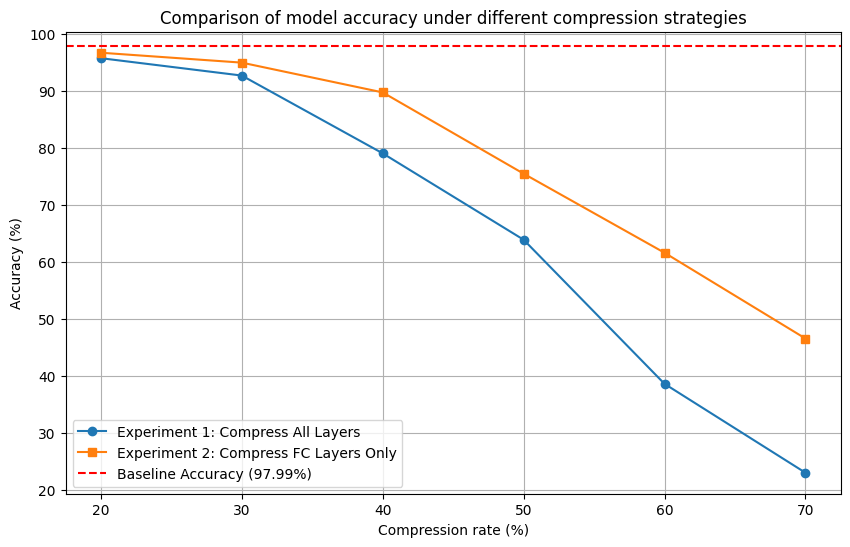

In [7]:
plt.figure(figsize=(10, 6))
plt.plot([r * 100 for r in compression_rates], accuracies_exp1, 'o-', label='Experiment 1: Compress All Layers')
plt.plot([r * 100 for r in compression_rates], accuracies_exp2, 's-', label='Experiment 2: Compress FC Layers Only')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label=f'Baseline Accuracy ({baseline_accuracy:.2f}%)')

plt.title('Comparison of model accuracy under different compression strategies')
plt.xlabel('Compression rate (%)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

### 总结


通过以上两个实验和可视化对比，我们可以得出以下结论：

1.  **低秩分解是有效的模型压缩方法**：通过低秩近似，我们可以在一定程度上减少模型参数，而不会导致灾难性的精度下降。
2.  **全连接层冗余度更高**：在LeNet这类模型中，全连接层通常占据大量参数，且冗余度较高。仅压缩全连接层可以在保持较高精度的同时实现可观的压缩效果。
3.  **压缩策略的重要性**：选择合适的压缩目标（哪些层）和压缩率是模型压缩的关键。盲目地对所有层应用高压缩率可能会严重损害模型性能。

这个实践展示了如何应用低秩分解进行模型压缩，并提供了一个分析压缩效果的基本框架。
